In [1]:
import glob
import json
import os
from collections import defaultdict
from pathlib import Path

import awkward as ak
import dask
import dask_awkward as dak
import hist.dask
import coffea
import numpy as np
import uproot
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("ggplot")

from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
from coffea import dataset_tools

import time
import warnings

warnings.filterwarnings("ignore")

from input_files import utils

from dask.distributed import LocalCluster, Client, progress, performance_report

# local: single thread, single worker
# cluster = LocalCluster(n_workers=1, processes=False, threads_per_worker=1)
# client = Client(cluster)

# for UChicago
client = Client("tcp://dask-alheld-f730f827-a.af-jupyter:8786")  # update this to point to your own client!

figures_dir = Path.cwd() / "figures"
figures_dir.mkdir(exist_ok=True)

print(f"awkward: {ak.__version__}")
print(f"dask-awkward: {dak.__version__}")
print(f"uproot: {uproot.__version__}")
print(f"hist: {hist.__version__}")
print(f"coffea: {coffea.__version__}")

awkward: 2.6.2
dask-awkward: 2024.3.0
uproot: 5.3.2
hist: 2.7.2
coffea: 2024.3.0


### interactive coffea for debugging

In [2]:
# fname = "/data/alheld/200gbps-atlas/data18_13TeV.periodAllYear.physics_Main.PhysCont.DAOD_PHYSLITE.grp18_v01_p6026/DAOD_PHYSLITE.37021624._000036.pool.root.1"
# treename = "CollectionTree"
# events = NanoEventsFactory.from_root({fname: treename}, schemaclass=PHYSLITESchema).events()

### distributed coffea

build a `fileset` using the list of files corresponding to some selected containers

In [3]:
# -------------
# CONFIGURATION
# -------------
# modify this to change how many files are being processed
# full list is list(find_containers.container_dict.keys()) + ["data15_13TeV", "data16_13TeV", "data17_13TeV", "data18_13TeV"]

PROCESSES_TO_USE = ["ttbar"]  # 6.7 TB
# PROCESSES_TO_USE = ["db", "zjets", "wjets", "ttV", "othertop", "ttbar"]  # all simulation, 48.4 TB
# PROCESSES_TO_USE = ["db", "zjets", "wjets", "ttV", "othertop", "ttbar", "data15_13TeV", "data16_13TeV", "data17_13TeV", "data18_13TeV"]  # 191 TB

fileset = utils.get_fileset(PROCESSES_TO_USE, max_files_per_container=1)

fileset summary
 - number of files: 3
cannot determine total size / number of events when max_files_per_container is being used


In [4]:
# check for files not yet replicated to MWT2
files_at_mwt2 = 0
files_elsewhere = 0
for process in fileset.keys():
    for file in fileset[process]["files"]:
        if "mwt2" in file:
            files_at_mwt2 += 1
        else:
            files_elsewhere += 1

print(f"files at MWT2: {files_at_mwt2}, elsewhere: {files_elsewhere}")

files at MWT2: 3, elsewhere: 0


In [5]:
def materialize_branches(events):
    # track number of events
    num_events = ak.num(events, axis=0)

    # this will read around 25% of data files
    # materialize branches, just derive integers from them that will be aggregated to avoid memory issues
    _counter = 0
    _counter += ak.count_nonzero(events.Jets.pt)
    _counter += ak.count_nonzero(events.Jets.eta)
    _counter += ak.count_nonzero(events.Jets.phi)
    _counter += ak.count_nonzero(events.Jets.m)
    _counter += ak.count_nonzero(events.Electrons.pt)
    _counter += ak.count_nonzero(events.Electrons.eta)
    _counter += ak.count_nonzero(events.Electrons.phi)
    _counter += ak.count_nonzero(events.Electrons.m)
    _counter += ak.count_nonzero(events.Muons.pt)
    _counter += ak.count_nonzero(events.Muons.eta)
    _counter += ak.count_nonzero(events.Muons.phi)
    _counter += ak.count_nonzero(events.Jets.EnergyPerSampling)
    _counter += ak.count_nonzero(events.Jets.SumPtTrkPt500)
    _counter += ak.count_nonzero(events.Jets.TrackWidthPt1000)
    _counter += ak.count_nonzero(events.PrimaryVertices.z)
    _counter += ak.count_nonzero(events.PrimaryVertices.x)
    _counter += ak.count_nonzero(events.PrimaryVertices.y)
    _counter += ak.count_nonzero(events.Jets.NumTrkPt500)
    _counter += ak.count_nonzero(events.Jets.NumTrkPt1000)
    _counter += ak.count_nonzero(events.Jets.SumPtChargedPFOPt500)
    _counter += ak.count_nonzero(events.Jets.Timing)
    _counter += ak.count_nonzero(events.Jets.JetConstitScaleMomentum_eta)
    _counter += ak.count_nonzero(events.Jets.ActiveArea4vec_eta)
    _counter += ak.count_nonzero(events.Jets.DetectorEta)
    _counter += ak.count_nonzero(events.Jets.JetConstitScaleMomentum_phi)
    _counter += ak.count_nonzero(events.Jets.ActiveArea4vec_phi)
    _counter += ak.count_nonzero(events.Jets.JetConstitScaleMomentum_m)
    _counter += ak.count_nonzero(events.Jets.JetConstitScaleMomentum_pt)
    _counter += ak.count_nonzero(events.Jets.EMFrac)
    _counter += ak.count_nonzero(events.Jets.Width)
    _counter += ak.count_nonzero(events.Jets.ActiveArea4vec_m)
    _counter += ak.count_nonzero(events.Jets.ActiveArea4vec_pt)
    _counter += ak.count_nonzero(events.Jets.DFCommonJets_QGTagger_TracksWidth)
    _counter += ak.count_nonzero(events.Jets.PSFrac)
    _counter += ak.count_nonzero(events.Jets.JVFCorr)
    _counter += ak.count_nonzero(events.Jets.DFCommonJets_QGTagger_TracksC1)
    _counter += ak.count_nonzero(events.Jets.DFCommonJets_fJvt)
    _counter += ak.count_nonzero(events.Jets.DFCommonJets_QGTagger_NTracks)
    _counter += ak.count_nonzero(events.Jets.GhostMuonSegmentCount)
    _counter += ak.count_nonzero(events.Muons.muonSegmentLinks['m_persIndex'])
    _counter += ak.count_nonzero(events.Muons.msOnlyExtrapolatedMuonSpectrometerTrackParticleLink['m_persIndex'])
    _counter += ak.count_nonzero(events.Muons.extrapolatedMuonSpectrometerTrackParticleLink['m_persIndex'])
    _counter += ak.count_nonzero(events.Muons.inDetTrackParticleLink['m_persIndex'])
    _counter += ak.count_nonzero(events.Muons.muonSpectrometerTrackParticleLink['m_persIndex'])
    _counter += ak.count_nonzero(events.Muons.momentumBalanceSignificance)
    _counter += ak.count_nonzero(events.Muons.topoetcone20_CloseByCorr)
    _counter += ak.count_nonzero(events.Muons.scatteringCurvatureSignificance)
    _counter += ak.count_nonzero(events.Muons.scatteringNeighbourSignificance)
    _counter += ak.count_nonzero(events.Muons.neflowisol20_CloseByCorr)
    _counter += ak.count_nonzero(events.Muons.topoetcone20)
    _counter += ak.count_nonzero(events.Muons.topoetcone30)
    _counter += ak.count_nonzero(events.Muons.topoetcone40)
    _counter += ak.count_nonzero(events.Muons.neflowisol20)
    _counter += ak.count_nonzero(events.Muons.segmentDeltaEta)
    _counter += ak.count_nonzero(events.Muons.DFCommonJetDr)
    _counter += ak.count_nonzero(events.Muons.combinedTrackParticleLink['m_persIndex'])
    _counter += ak.count_nonzero(events.Muons.InnerDetectorPt)
    _counter += ak.count_nonzero(events.Muons.MuonSpectrometerPt)
    _counter += ak.count_nonzero(events.Muons.clusterLink['m_persIndex'])
    _counter += ak.count_nonzero(events.Muons.spectrometerFieldIntegral)
    _counter += ak.count_nonzero(events.Electrons.ambiguityLink['m_persIndex'])
    _counter += ak.count_nonzero(events.Muons.EnergyLoss)
    _counter += ak.count_nonzero(events.Jets.NNJvtPass)
    _counter += ak.count_nonzero(events.Electrons.topoetcone20_CloseByCorr)
    _counter += ak.count_nonzero(events.Electrons.topoetcone20ptCorrection)
    _counter += ak.count_nonzero(events.Electrons.topoetcone20)
    _counter += ak.count_nonzero(events.Muons.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt500_CloseByCorr)
    _counter += ak.count_nonzero(events.Electrons.DFCommonElectronsECIDSResult)
    _counter += ak.count_nonzero(events.Electrons.neflowisol20)
    _counter += ak.count_nonzero(events.Muons.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt500)
    _counter += ak.count_nonzero(events.Muons.ptcone40)
    _counter += ak.count_nonzero(events.Muons.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000_CloseByCorr)
    _counter += ak.count_nonzero(events.Muons.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000)
    _counter += ak.count_nonzero(events.Muons.ptvarcone40)
    _counter += ak.count_nonzero(events.Electrons.f1)
    _counter += ak.count_nonzero(events.Muons.ptcone20_Nonprompt_All_MaxWeightTTVA_pt500)
    _counter += ak.count_nonzero(events.PrimaryVertices.vertexType)
    _counter += ak.count_nonzero(events.Muons.ptvarcone30)
    _counter += ak.count_nonzero(events.Muons.ptcone30)
    _counter += ak.count_nonzero(events.Muons.ptcone20_Nonprompt_All_MaxWeightTTVA_pt1000)
    _counter += ak.count_nonzero(events.Electrons.ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500)
    _counter += ak.count_nonzero(events.Muons.CaloLRLikelihood)

    return {"nevts": num_events, "_counter": _counter}

In [6]:
%%time
# pre-process
samples, report = dataset_tools.preprocess(fileset, skip_bad_files=True, uproot_options={"allow_read_errors_with_report": True})

CPU times: user 62.8 ms, sys: 14.3 ms, total: 77.1 ms
Wall time: 2.36 s


In [7]:
# find issues where access did not work
for process in report:
    for k, v in report[process]["files"].items():
        if v["steps"] is None:
            print(f"could not read {k}")

In [8]:
BRANCH_LIST = [
    "AnalysisJetsAuxDyn.pt",
    "AnalysisJetsAuxDyn.eta",
    "AnalysisJetsAuxDyn.phi",
    "AnalysisJetsAuxDyn.m",
    "AnalysisElectronsAuxDyn.pt",
    "AnalysisElectronsAuxDyn.eta",
    "AnalysisElectronsAuxDyn.phi",
    "AnalysisElectronsAuxDyn.m",
    "AnalysisMuonsAuxDyn.pt",
    "AnalysisMuonsAuxDyn.eta",
    "AnalysisMuonsAuxDyn.phi",
    "AnalysisJetsAuxDyn.EnergyPerSampling",
    "AnalysisJetsAuxDyn.SumPtTrkPt500",
    "AnalysisJetsAuxDyn.TrackWidthPt1000",
    "PrimaryVerticesAuxDyn.z",
    "PrimaryVerticesAuxDyn.x",
    "PrimaryVerticesAuxDyn.y",
    "AnalysisJetsAuxDyn.NumTrkPt500",
    "AnalysisJetsAuxDyn.NumTrkPt1000",
    "AnalysisJetsAuxDyn.SumPtChargedPFOPt500",
    "AnalysisJetsAuxDyn.Timing",
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_eta",
    "AnalysisJetsAuxDyn.ActiveArea4vec_eta",
    "AnalysisJetsAuxDyn.DetectorEta",
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_phi",
    "AnalysisJetsAuxDyn.ActiveArea4vec_phi",
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_m",
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_pt",
    "AnalysisJetsAuxDyn.EMFrac",
    "AnalysisJetsAuxDyn.Width",
    "AnalysisJetsAuxDyn.ActiveArea4vec_m",
    "AnalysisJetsAuxDyn.ActiveArea4vec_pt",
    "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_TracksWidth",
    "AnalysisJetsAuxDyn.PSFrac",
    "AnalysisJetsAuxDyn.JVFCorr",
    "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_TracksC1",
    "AnalysisJetsAuxDyn.DFCommonJets_fJvt",
    "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_NTracks",
    "AnalysisJetsAuxDyn.GhostMuonSegmentCount",
    "AnalysisMuonsAuxDyn.muonSegmentLinks",
    "AnalysisMuonsAuxDyn.msOnlyExtrapolatedMuonSpectrometerTrackParticleLink",
    "AnalysisMuonsAuxDyn.extrapolatedMuonSpectrometerTrackParticleLink",
    "AnalysisMuonsAuxDyn.inDetTrackParticleLink",
    "AnalysisMuonsAuxDyn.muonSpectrometerTrackParticleLink",
    "AnalysisMuonsAuxDyn.momentumBalanceSignificance",
    "AnalysisMuonsAuxDyn.topoetcone20_CloseByCorr",
    "AnalysisMuonsAuxDyn.scatteringCurvatureSignificance",
    "AnalysisMuonsAuxDyn.scatteringNeighbourSignificance",
    "AnalysisMuonsAuxDyn.neflowisol20_CloseByCorr",
    "AnalysisMuonsAuxDyn.topoetcone20",
    "AnalysisMuonsAuxDyn.topoetcone30",
    "AnalysisMuonsAuxDyn.topoetcone40",
    "AnalysisMuonsAuxDyn.neflowisol20",
    "AnalysisMuonsAuxDyn.segmentDeltaEta",
    "AnalysisMuonsAuxDyn.DFCommonJetDr",
    "AnalysisMuonsAuxDyn.combinedTrackParticleLink",
    "AnalysisMuonsAuxDyn.InnerDetectorPt",
    "AnalysisMuonsAuxDyn.MuonSpectrometerPt",
    "AnalysisMuonsAuxDyn.clusterLink",
    "AnalysisMuonsAuxDyn.spectrometerFieldIntegral",
    "AnalysisElectronsAuxDyn.ambiguityLink",
    "AnalysisMuonsAuxDyn.EnergyLoss",
    "AnalysisJetsAuxDyn.NNJvtPass",
    "AnalysisElectronsAuxDyn.topoetcone20_CloseByCorr",
    "AnalysisElectronsAuxDyn.topoetcone20ptCorrection",
    "AnalysisElectronsAuxDyn.topoetcone20",
    "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt500_CloseByCorr",
    "AnalysisElectronsAuxDyn.DFCommonElectronsECIDSResult",
    "AnalysisElectronsAuxDyn.neflowisol20",
    "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt500",
    "AnalysisMuonsAuxDyn.ptcone40",
    "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000_CloseByCorr",
    "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000",
    "AnalysisMuonsAuxDyn.ptvarcone40",
    "AnalysisElectronsAuxDyn.f1",
    "AnalysisMuonsAuxDyn.ptcone20_Nonprompt_All_MaxWeightTTVA_pt500",
    "PrimaryVerticesAuxDyn.vertexType",
    "AnalysisMuonsAuxDyn.ptvarcone30",
    "AnalysisMuonsAuxDyn.ptcone30",
    "AnalysisMuonsAuxDyn.ptcone20_Nonprompt_All_MaxWeightTTVA_pt1000",
    "AnalysisElectronsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500",
    "AnalysisMuonsAuxDyn.CaloLRLikelihood"
]

filter_name = lambda name: name in BRANCH_LIST

In [9]:
%%time
# create the task graph
# filter_name seems to not do anything here in terms of performance
tasks = dataset_tools.apply_to_fileset(materialize_branches,
                                       samples,
                                       uproot_options={"allow_read_errors_with_report": True, "filter_name": filter_name},
                                       schemaclass=PHYSLITESchema)

CPU times: user 3.96 s, sys: 111 ms, total: 4.07 s
Wall time: 4.09 s


execute task graph

In [10]:
%%time
# execute
t0 = time.perf_counter()
with performance_report(filename="dask-report.html"):
    ((out, report),) = dask.compute(tasks)  # feels strange that this is a tuple-of-tuple
t1 = time.perf_counter()

print(f"total time spent in uproot reading data: {ak.sum([v['duration'] for v in report.values()]):.2f} s")
print(f"wall time: {t1-t0:.2f}s")

total time spent in uproot reading data: 40.30 s
wall time: 20.30s
CPU times: user 550 ms, sys: 73.8 ms, total: 624 ms
Wall time: 20.3 s


In [11]:
print(f"output: {out}")

print("\nperformance metrics:")

event_rate = sum([out[process]["nevts"] for process in out.keys()]) / (t1-t0)
print(f" - event rate: {event_rate / 1_000:.2f} kHz")

# need uproot>=5.3.2 to get these useful performance stats
num_bytes = ak.sum([report[process]["performance_counters"]["num_requested_bytes"] for process in out.keys()])
read_MB = num_bytes / 1_000**2
rate_Mbs = read_MB / (t1-t0)
print(f" - read {read_MB:.2f} MB in {t1-t0:.2f} s -> {rate_Mbs:.2f} MBps (need to scale by x{200/8/rate_Mbs*1000:.0f} to reach 200 Gbps)")

output: {'ttbar': {'nevts': 80000, '_counter': 53556499}}

performance metrics:
 - event rate: 3.94 kHz
 - read 261.50 MB in 20.30 s -> 12.88 MBps (need to scale by x1941 to reach 200 Gbps)


In [12]:
# sanity check that the right colums are being touched
dak.report_necessary_columns(tasks)

{'from-uproot-08c819d5b3e2667624a7b22c8e1cbdd5': frozenset({'AnalysisElectronsAuxDyn.DFCommonElectronsECIDSResult',
            'AnalysisElectronsAuxDyn.ambiguityLink',
            'AnalysisElectronsAuxDyn.eta',
            'AnalysisElectronsAuxDyn.f1',
            'AnalysisElectronsAuxDyn.m',
            'AnalysisElectronsAuxDyn.neflowisol20',
            'AnalysisElectronsAuxDyn.phi',
            'AnalysisElectronsAuxDyn.pt',
            'AnalysisElectronsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500',
            'AnalysisElectronsAuxDyn.topoetcone20',
            'AnalysisElectronsAuxDyn.topoetcone20_CloseByCorr',
            'AnalysisElectronsAuxDyn.topoetcone20ptCorrection',
            'AnalysisJetsAuxDyn.ActiveArea4vec_eta',
            'AnalysisJetsAuxDyn.ActiveArea4vec_m',
            'AnalysisJetsAuxDyn.ActiveArea4vec_phi',
            'AnalysisJetsAuxDyn.ActiveArea4vec_pt',
            'AnalysisJetsAuxDyn.DFCommonJets_QGTagger_NTracks',
            'Analysis

## sanity check: read those columns without any Dask / coffea, compare footprint

this does not scale and uses a single hardcoded file

In [13]:
branches_touched = list(list(dak.report_necessary_columns(tasks).values())[0])

fname = "/data/alheld/200gbps-atlas/data18_13TeV.periodAllYear.physics_Main.PhysCont.DAOD_PHYSLITE.grp18_v01_p6026/DAOD_PHYSLITE.37021624._000036.pool.root.1"
treename = "CollectionTree"
t = uproot.open({fname: treename})

initial_size_in_MB = t.file.source.num_requested_bytes/1000**2  # non-zero at the start (some metadata read)

t.arrays(branches_touched)

new_size_in_MB = t.file.source.num_requested_bytes/1000**2
print(initial_size_in_MB, new_size_in_MB)

2.260006 283.192324


This should match the numbers reported above through coffea, but it currently does not! This needs to be understood.

## rest of the notebook: non-Dask / non-coffea local tests for performance comparisons

In [14]:
# time each branch individually, compare to size of the branch, ensure no extreme outliers are present
for i in range(len(BRANCH_LIST)):
    with uproot.open({fname: treename}, filter_name=filter_name) as f:
        initial_metadata_in_MB = f.file.source.num_requested_bytes/1000**2
        t0 = time.perf_counter()
        f[BRANCH_LIST[i]].array()
        t1 = time.perf_counter()
        new_size_in_MB = f.file.source.num_requested_bytes/1000**2
        time_ms = (t1-t0)*1000
        size_MB = (new_size_in_MB-initial_metadata_in_MB)
        print(f"{BRANCH_LIST[i]:<80}: {time_ms:4.0f} ms\t\t{size_MB:>5.2f} MB\t\t{size_MB / time_ms * 1000:>5.1f} MB/s")

AnalysisJetsAuxDyn.pt                                                           :  341 ms		 5.03 MB		 14.7 MB/s
AnalysisJetsAuxDyn.eta                                                          :  341 ms		 5.25 MB		 15.4 MB/s
AnalysisJetsAuxDyn.phi                                                          :  341 ms		 5.24 MB		 15.4 MB/s
AnalysisJetsAuxDyn.m                                                            :  338 ms		 5.05 MB		 15.0 MB/s
AnalysisElectronsAuxDyn.pt                                                      :  455 ms		 0.67 MB		  1.5 MB/s
AnalysisElectronsAuxDyn.eta                                                     :  456 ms		 0.68 MB		  1.5 MB/s
AnalysisElectronsAuxDyn.phi                                                     :  457 ms		 0.68 MB		  1.5 MB/s
AnalysisElectronsAuxDyn.m                                                       :  461 ms		 0.43 MB		  0.9 MB/s
AnalysisMuonsAuxDyn.pt                                                          :  456 ms		 0.74 MB		  1

In [15]:
file_size = os.path.getsize(fname) / 1000**2  # all sizes in MB

time_per_fraction_read = {}
for i in range(len(BRANCH_LIST)//12+1):
    with uproot.open({fname: treename}, filter_name=filter_name) as f:  # re-open every time for accurate tracking of data read
        branches = BRANCH_LIST[0:(i+1)*12]
        print(f"reading {len(branches)} branch(es)")
        initial_metadata_in_MB = f.file.source.num_requested_bytes/1000**2
        t0 = time.perf_counter()
        f.arrays(branches)
        t1 = time.perf_counter()
        new_size_in_MB = f.file.source.num_requested_bytes/1000**2
        fraction_read = (new_size_in_MB - initial_metadata_in_MB) / file_size
        time_per_fraction_read[fraction_read] = t1 - t0
        print(f"  - read {new_size_in_MB - initial_metadata_in_MB:.2f} MB in {t1 - t0:.2f} s")

with uproot.open({fname: treename}) as f:
    nevts = f.num_entries

reading 12 branch(es)
  - read 64.08 MB in 7.04 s
reading 24 branch(es)
  - read 191.08 MB in 20.51 s
reading 36 branch(es)
  - read 245.91 MB in 24.55 s
reading 48 branch(es)
  - read 257.35 MB in 32.44 s
reading 60 branch(es)
  - read 266.31 MB in 39.86 s
reading 72 branch(es)
  - read 274.57 MB in 45.74 s
reading 82 branch(es)
  - read 280.93 MB in 50.45 s


The fraction of the file being depends on the file type and may differ from data, where the derivation of these branches was performed to hit 25%.

In [16]:
for k, v in time_per_fraction_read.items():
    print(f"fraction read: {k:.2%} in {v:.2f} s")

fraction read: 5.70% in 7.04 s
fraction read: 17.01% in 20.51 s
fraction read: 21.89% in 24.55 s
fraction read: 22.91% in 32.44 s
fraction read: 23.70% in 39.86 s
fraction read: 24.44% in 45.74 s
fraction read: 25.01% in 50.45 s


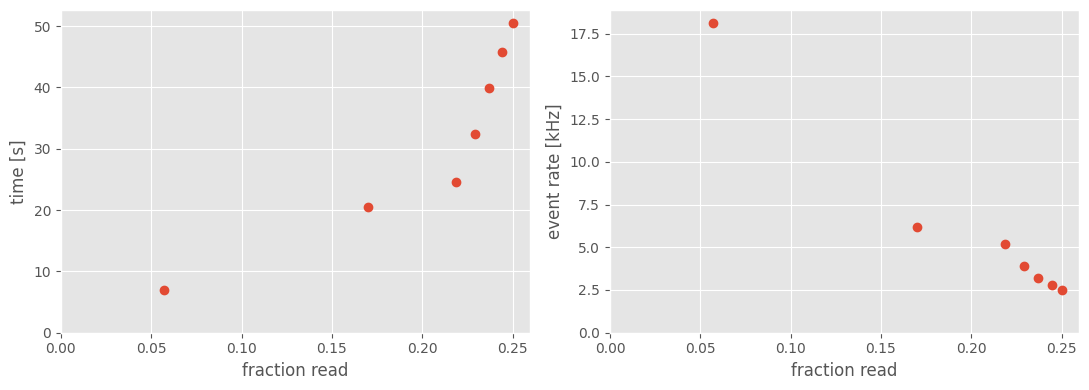

In [17]:
event_rate_in_kHz = nevts / np.fromiter(time_per_fraction_read.values(), np.float32) / 1_000

fig, (ax0, ax1) = plt.subplots(figsize=(11,4), ncols=2)

ax0.plot(time_per_fraction_read.keys(), time_per_fraction_read.values(), "o")
ax0.set_xlabel("fraction read")
ax0.set_ylabel("time [s]")
ax0.set_xlim([0, ax0.get_xlim()[1]])
ax0.set_ylim([0, ax0.get_ylim()[1]])

ax1.plot(time_per_fraction_read.keys(), event_rate_in_kHz, "o")
ax1.set_xlabel("fraction read")
ax1.set_ylabel("event rate [kHz]")
ax1.set_xlim([0, ax1.get_xlim()[1]])
ax1.set_ylim([0, ax1.get_ylim()[1]])

fig.tight_layout()
fig.savefig(figures_dir / "file_read_time.png", dpi=300)

In [18]:
# pure "metadata" (?) part, would be read on every open call
with uproot.open({fname: treename}) as f:
    print(f"{f.file.source.num_requested_bytes/1000**2:.2f} MB")

2.26 MB


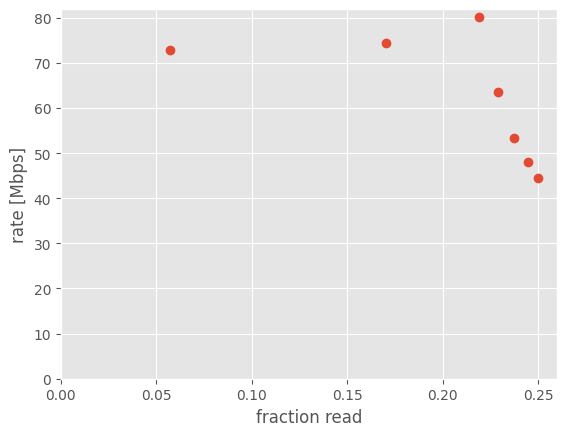

In [19]:
# fraction read * file size (in MB) * 8 (to Mb) / time (in s)
io_in_Mbps = np.fromiter(time_per_fraction_read.keys(), np.float32) * file_size * 8 / np.fromiter(time_per_fraction_read.values(), np.float32)

fig, ax = plt.subplots()

ax.plot(time_per_fraction_read.keys(), io_in_Mbps, "o")
ax.set_xlabel("fraction read")
ax.set_ylabel("rate [Mbps]")
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_ylim([0, ax.get_ylim()[1]])

fig.savefig(figures_dir / "file_read_rate.png", dpi=300)